In [618]:
from datetime import date
today = date.today()

In [619]:
#stock = ['SPY', 'GLD', 'SPLB', 'EEM', 'QQQ', 'SLV', 'HYG', 'VWO', 'TLT', 'FXI']
stock = ['SPY']
sampling = ['daily', 'weekly'][0]
aggregation = ['last_day', 'mean'][0]
#stock = ['VTI', 'VEU', 'VNQ', 'BND', 'GSG']
date_start = '1993-01-01'
date_end = today.strftime("%Y-%m-%d")

In [620]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas_datareader as pdr
import statsmodels.api as sm
import scipy.stats as scs

In [621]:
combined_data = []
for i in range(len(stock)):
    df = pdr.DataReader(stock[i], 
                       start=date_start, 
                       end=date_end, 
                       data_source='yahoo')
    name = stock[i]
    df_stock = df[['Adj Close']]
    df_stock = df_stock.rename(columns={"Adj Close" : name})
    if i > 0:
        combined_data = pd.concat([combined_data, df_stock], axis = 1)
    else:
        combined_data = df_stock
        
    
    #combined_data.append(df_stock)
    #combined_data.append(df_stock)
    #combined_data = pd.concat([combined_data, df_stock], axis=1, join="inner" )
    #df1.append(df4, ignore_index=True, sort=False)
    #result = pd.concat([df1, df4], axis=1, join="inner")
if sampling == 'weekly':
    if aggregation == 'last_day':
        combined_data = combined_data.resample('W').agg('last')
    elif aggregation == "mean":
        combined_data = combined_data.resample('W').agg('mean')

In [622]:
combined_data

,SPY
Date,
1993-01-29,25.968958
1993-02-01,26.153660
1993-02-02,26.209057
1993-02-03,26.486113
1993-02-04,26.596937
...,...
2021-02-22,387.029999
2021-02-23,387.500000
2021-02-24,391.769989


<AxesSubplot:xlabel='Date'>

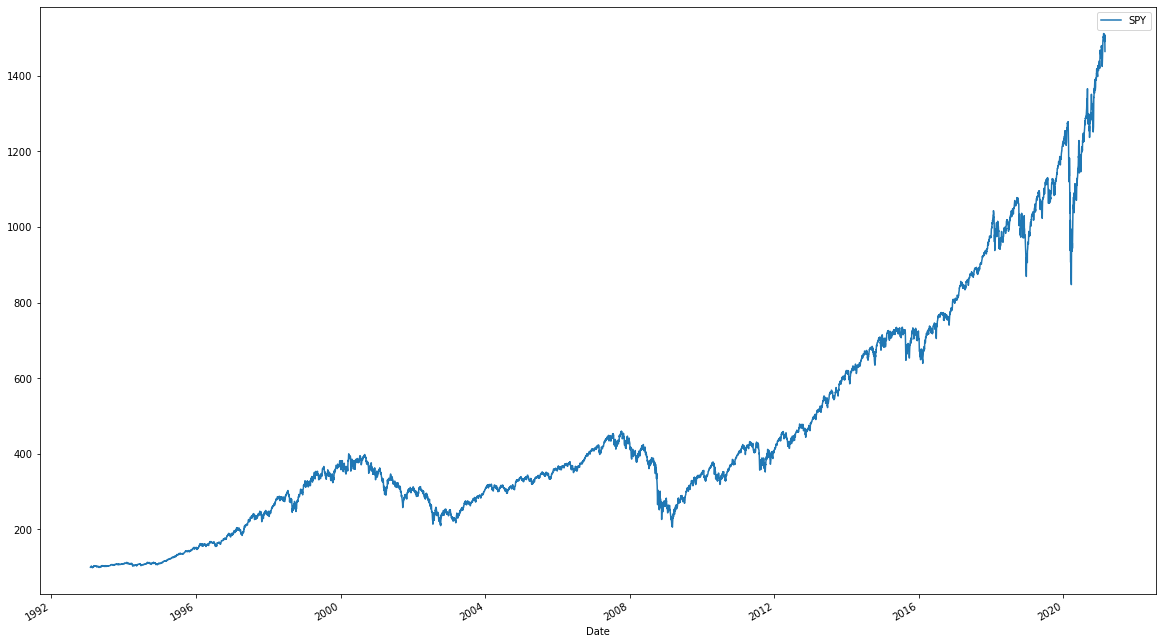

In [623]:
(combined_data / combined_data.iloc[0] * 100).plot(figsize=(20, 12))

In [624]:
combined_data['return'] = np.log(combined_data / combined_data.shift(1))
combined_data['direction'] = np.where(combined_data['return'] > 0, 1, 0)
combined_data.dropna(inplace=True)
combined_data.head()

,SPY,return,direction
Date,,,
1993-02-01,26.153660,0.007087,1
1993-02-02,26.209057,0.002116,1
1993-02-03,26.486113,0.010516,1
1993-02-04,26.596937,0.004176,1
1993-02-05,26.578478,-0.000694,0


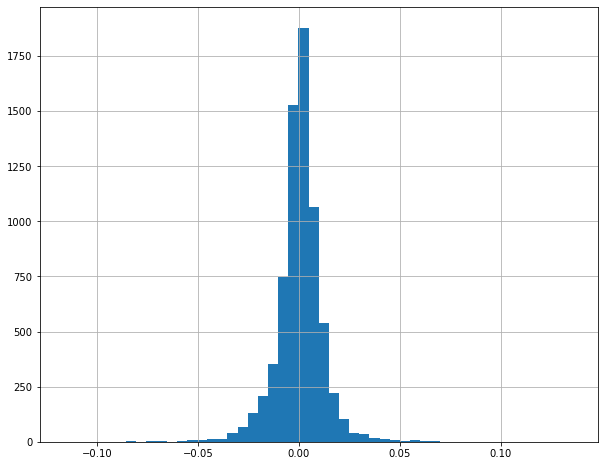

In [625]:
combined_data['return'].hist(bins=50, figsize=(10, 8));

# Feature Engineering

In [626]:
import ta
from ta.volatility import BollingerBands

In [627]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    combined_data[col] = combined_data['return'].shift(lag)
    cols.append(col)
combined_data.dropna(inplace=True)

In [628]:
indicator_bb = BollingerBands(close=combined_data['SPY'], window=20, window_dev=2)
bb = pd.DataFrame()
bb['bb_bbm'] = indicator_bb.bollinger_mavg()
bb['bb_bbh'] = indicator_bb.bollinger_hband()
bb['bb_bbl'] = indicator_bb.bollinger_lband()

mini, maxi = bb['bb_bbm'].min(), bb['bb_bbm'].max()
bb['bb_bbm_norm'] = (bb['bb_bbm'] - mini) / (maxi - mini)

mini, maxi = bb['bb_bbm'].min(), bb['bb_bbh'].max()
bb['bb_bbh_norm'] = (bb['bb_bbh'] - mini) / (maxi - mini)

mini, maxi = bb['bb_bbl'].min(), bb['bb_bbl'].max()
bb['bb_bbl_norm'] = (bb['bb_bbl'] - mini) / (maxi - mini)

In [629]:
from ta.trend import MACD

In [630]:
indicator_macd = MACD(close = combined_data['SPY'], window_slow = 26, window_fast = 12, window_sign = 9, fillna = False)
macd = pd.DataFrame()
macd['macd'] = indicator_macd.macd()
macd['macd_diff'] = indicator_macd.macd_diff()
macd['macd_signal'] = indicator_macd.macd_signal()

mini, maxi = macd['macd'].min(), macd['macd'].max()
macd['macd_norm'] = (macd['macd'] - maxi) / (maxi - mini)

mini, maxi = macd['macd_diff'].min(), macd['macd_diff'].max()
macd['macd_diff_norm'] = (macd['macd_diff'] - maxi) / (maxi - mini)

mini, maxi = macd['macd_signal'].min(), macd['macd_signal'].max()
macd['macd_signal_norm'] = (macd['macd_signal'] - maxi) / (maxi - mini)

In [631]:
normalised_features = pd.merge(bb[['bb_bbm_norm', 'bb_bbh_norm', 'bb_bbl_norm']],macd[['macd_norm','macd_diff_norm', 'macd_signal_norm']], on='Date', how = 'left')

In [632]:
normalised_features

,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm
Date,,,,,,
1993-02-08,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-09,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-10,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-11,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-12,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-02-22,0.996984,0.997848,0.993797,-0.162088,-0.525438,-0.128308
2021-02-23,0.997415,0.998309,0.994195,-0.173743,-0.545272,-0.133390
2021-02-24,0.998522,1.000000,0.994673,-0.173556,-0.535732,-0.137411


In [633]:
combined_data = pd.merge(combined_data, normalised_features, on='Date', how = 'left')

In [634]:
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm
Date,,,,,,,,,,,,,,
1993-02-08,26.578478,0.000000,0,-0.000694,0.004176,0.010516,0.002116,0.007087,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-09,26.393753,-0.006974,0,0.000000,-0.000694,0.004176,0.010516,0.002116,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-10,26.430716,0.001399,1,-0.006974,0.000000,-0.000694,0.004176,0.010516,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-11,26.559996,0.004879,1,0.001399,-0.006974,0.000000,-0.000694,0.004176,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-12,26.356831,-0.007679,0,0.004879,0.001399,-0.006974,0.000000,-0.000694,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,387.029999,-0.007721,0,-0.001768,-0.004265,0.000229,-0.000866,0.004928,0.996984,0.997848,0.993797,-0.162088,-0.525438,-0.128308
2021-02-23,387.500000,0.001214,1,-0.007721,-0.001768,-0.004265,0.000229,-0.000866,0.997415,0.998309,0.994195,-0.173743,-0.545272,-0.133390
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,0.998522,1.000000,0.994673,-0.173556,-0.535732,-0.137411


In [635]:
combined_data['momentum'] = combined_data['return'].rolling(5).mean().shift(1)
combined_data['volatility'] = combined_data['return'].rolling(20).std().shift(1)
#combined_data['distance'] = (combined_data[stock] - combined_data[stock].rolling(50).mean()).shift(1)
combined_data.dropna(inplace=True)
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm,momentum,volatility
Date,,,,,,,,,,,,,,,,
1993-03-26,26.666868,-0.005552,0,0.006248,0.000000,0.002091,-0.005567,-0.001515,0.001313,0.002325,0.002606,-0.279926,-0.501370,-0.279627,0.000252,0.007443
1993-03-29,26.778231,0.004167,1,-0.005552,0.006248,0.000000,0.002091,-0.005567,0.001397,0.002184,0.002929,-0.279886,-0.500928,-0.279776,-0.000556,0.007591
1993-03-30,26.852465,0.002768,1,0.004167,-0.005552,0.006248,0.000000,0.002091,0.001437,0.002207,0.002989,-0.279700,-0.500259,-0.279852,0.001391,0.007577
1993-03-31,26.833904,-0.000691,0,0.002768,0.004167,-0.005552,0.006248,0.000000,0.001460,0.002230,0.003012,-0.279631,-0.499974,-0.279895,0.001526,0.006891
1993-04-01,26.741098,-0.003465,0,-0.000691,0.002768,0.004167,-0.005552,0.006248,0.001490,0.002209,0.003097,-0.279837,-0.500338,-0.279979,0.001388,0.006842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,387.029999,-0.007721,0,-0.001768,-0.004265,0.000229,-0.000866,0.004928,0.996984,0.997848,0.993797,-0.162088,-0.525438,-0.128308,-0.000348,0.009811
2021-02-23,387.500000,0.001214,1,-0.007721,-0.001768,-0.004265,0.000229,-0.000866,0.997415,0.998309,0.994195,-0.173743,-0.545272,-0.133390,-0.002878,0.009950
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,0.998522,1.000000,0.994673,-0.173556,-0.535732,-0.137411,-0.002462,0.009920


<AxesSubplot:xlabel='Date'>

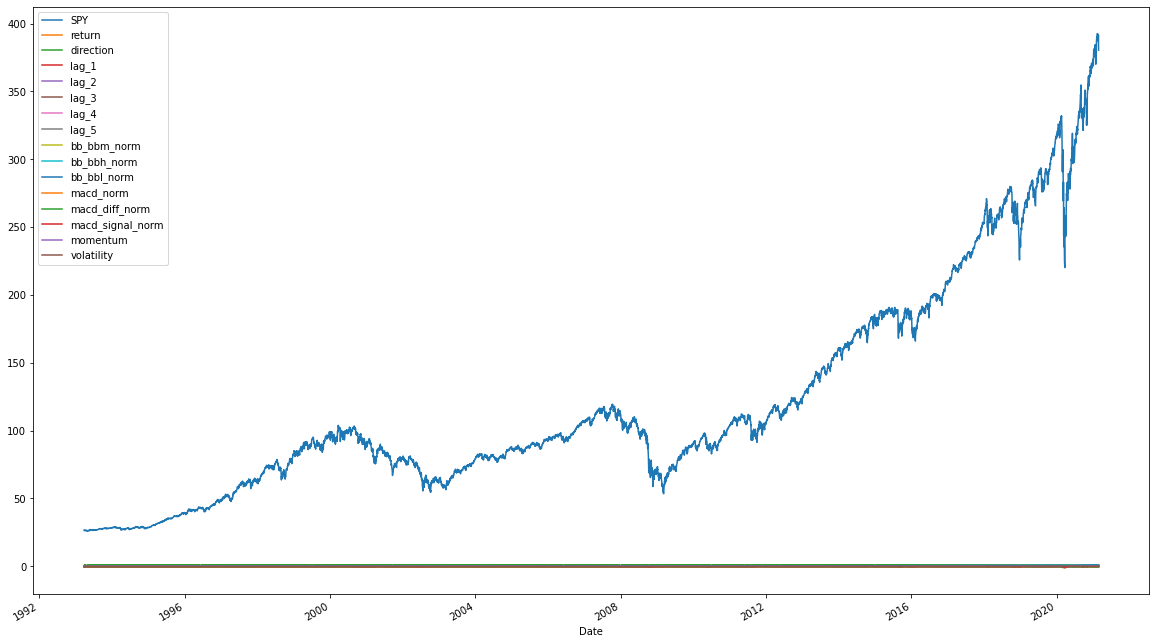

In [636]:
combined_data.plot(figsize=(20, 12))

# Which columns to use for training

In [664]:
cols = list(combined_data.columns)

In [665]:
cols = cols[3:]
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'bb_bbm_norm',
 'bb_bbh_norm',
 'bb_bbl_norm',
 'macd_norm',
 'macd_diff_norm',
 'macd_signal_norm',
 'momentum',
 'volatility']

# Linear Regression

In [666]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [667]:
combined_data_linear = combined_data.copy()
combined_data_linear

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm,momentum,volatility
Date,,,,,,,,,,,,,,,,
1993-03-26,26.666868,-0.005552,0,0.006248,0.000000,0.002091,-0.005567,-0.001515,0.001313,0.002325,0.002606,-0.279926,-0.501370,-0.279627,0.000252,0.007443
1993-03-29,26.778231,0.004167,1,-0.005552,0.006248,0.000000,0.002091,-0.005567,0.001397,0.002184,0.002929,-0.279886,-0.500928,-0.279776,-0.000556,0.007591
1993-03-30,26.852465,0.002768,1,0.004167,-0.005552,0.006248,0.000000,0.002091,0.001437,0.002207,0.002989,-0.279700,-0.500259,-0.279852,0.001391,0.007577
1993-03-31,26.833904,-0.000691,0,0.002768,0.004167,-0.005552,0.006248,0.000000,0.001460,0.002230,0.003012,-0.279631,-0.499974,-0.279895,0.001526,0.006891
1993-04-01,26.741098,-0.003465,0,-0.000691,0.002768,0.004167,-0.005552,0.006248,0.001490,0.002209,0.003097,-0.279837,-0.500338,-0.279979,0.001388,0.006842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,387.029999,-0.007721,0,-0.001768,-0.004265,0.000229,-0.000866,0.004928,0.996984,0.997848,0.993797,-0.162088,-0.525438,-0.128308,-0.000348,0.009811
2021-02-23,387.500000,0.001214,1,-0.007721,-0.001768,-0.004265,0.000229,-0.000866,0.997415,0.998309,0.994195,-0.173743,-0.545272,-0.133390,-0.002878,0.009950
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,0.998522,1.000000,0.994673,-0.173556,-0.535732,-0.137411,-0.002462,0.009920


In [668]:
lim = linear_model.LinearRegression()

In [595]:
X = combined_data_linear[cols]
y = combined_data_linear['return']

In [596]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
        random_state=42)

In [597]:
cv = cross_val_score(lim, X_test, y_test, cv=10)
cv.mean()

0.0388110770787113

In [598]:
lim.fit(X, y)

LinearRegression()

In [669]:
combined_data_linear['pos_ols_1'] = lim.fit(combined_data_linear[cols], combined_data_linear['return']).predict(combined_data_linear[cols])
combined_data_linear['pos_ols_2'] = lim.fit(combined_data_linear[cols], combined_data_linear['direction']).predict(combined_data_linear[cols])

In [670]:
combined_data_linear[['pos_ols_1']] = np.where(combined_data_linear[['pos_ols_1']] > 0, 1, -1)
combined_data_linear[['pos_ols_2']] = np.where(combined_data_linear[['pos_ols_2']] > 0, 1, -1)

In [671]:
combined_data_linear['pos_ols_1'].value_counts()

 1    4156
-1    2876
Name: pos_ols_1, dtype: int64

In [672]:
combined_data_linear['pos_ols_2'].value_counts()

 1    7026
-1       6
Name: pos_ols_2, dtype: int64

Number of trades

In [673]:
(combined_data_linear['pos_ols_1'].diff() != 0).sum()

2034

In [674]:
(combined_data_linear['pos_ols_2'].diff() != 0).sum()

13

In [675]:
combined_data_linear

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm,momentum,volatility,pos_ols_1,pos_ols_2
Date,,,,,,,,,,,,,,,,,,
1993-03-26,26.666868,-0.005552,0,0.006248,0.000000,0.002091,-0.005567,-0.001515,0.001313,0.002325,0.002606,-0.279926,-0.501370,-0.279627,0.000252,0.007443,1,1
1993-03-29,26.778231,0.004167,1,-0.005552,0.006248,0.000000,0.002091,-0.005567,0.001397,0.002184,0.002929,-0.279886,-0.500928,-0.279776,-0.000556,0.007591,1,1
1993-03-30,26.852465,0.002768,1,0.004167,-0.005552,0.006248,0.000000,0.002091,0.001437,0.002207,0.002989,-0.279700,-0.500259,-0.279852,0.001391,0.007577,-1,1
1993-03-31,26.833904,-0.000691,0,0.002768,0.004167,-0.005552,0.006248,0.000000,0.001460,0.002230,0.003012,-0.279631,-0.499974,-0.279895,0.001526,0.006891,-1,1
1993-04-01,26.741098,-0.003465,0,-0.000691,0.002768,0.004167,-0.005552,0.006248,0.001490,0.002209,0.003097,-0.279837,-0.500338,-0.279979,0.001388,0.006842,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,387.029999,-0.007721,0,-0.001768,-0.004265,0.000229,-0.000866,0.004928,0.996984,0.997848,0.993797,-0.162088,-0.525438,-0.128308,-0.000348,0.009811,-1,1
2021-02-23,387.500000,0.001214,1,-0.007721,-0.001768,-0.004265,0.000229,-0.000866,0.997415,0.998309,0.994195,-0.173743,-0.545272,-0.133390,-0.002878,0.009950,-1,1
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,0.998522,1.000000,0.994673,-0.173556,-0.535732,-0.137411,-0.002462,0.009920,-1,1


In [676]:
combined_data_linear['strat_ols_1'] = combined_data_linear['return']*combined_data_linear['pos_ols_1']
combined_data_linear['strat_ols_2'] = combined_data_linear['return']*combined_data_linear['pos_ols_2']

In [677]:
accuracy_score(combined_data_linear['pos_ols_1'],
               np.sign(combined_data_linear['return']))

0.5802047781569966

In [678]:
accuracy_score(combined_data_linear['pos_ols_2'],
               np.sign(combined_data_linear['return']))

0.5412400455062572

In [679]:
combined_data_linear[['return', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

return         1.418442e+01
strat_ols_1    1.019784e+06
strat_ols_2    2.986286e+01
dtype: float64

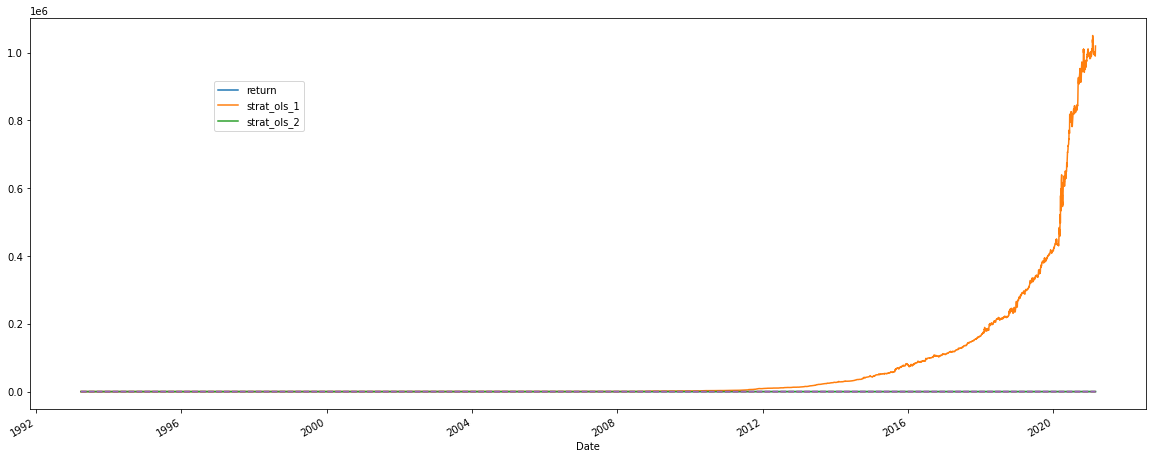

In [680]:
ax = combined_data_linear[['return', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(
                                        figsize=(20, 8));
combined_data_linear['pos_ols_1'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
combined_data_linear['pos_ols_2'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

# Logistic Regression

In [714]:
combined_data_logistic = combined_data.copy()

In [717]:
lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=10000)

In [718]:
lm.fit(combined_data_logistic[cols], np.sign(combined_data_logistic['return']))

LogisticRegression(C=10000000.0, max_iter=10000)

In [719]:
combined_data_logistic['prediction'] = lm.predict(combined_data_logistic[cols])

In [720]:
combined_data_logistic['prediction'].value_counts()

 1.0    5566
-1.0    1466
Name: prediction, dtype: int64

In [721]:
hits = np.sign(combined_data_logistic['return'].iloc[lags:] *
               combined_data_logistic['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    4050
-1.0    2920
 0.0      57
dtype: int64

In [723]:
accuracy_score(combined_data_logistic['prediction'],
               np.sign(combined_data_logistic['return']))

0.5762229806598407

In [730]:
combined_data_logistic['strategy'] = combined_data_logistic['return']*combined_data_logistic['prediction'].shift(1)

In [731]:
combined_data_logistic[['return', 'strategy']].sum().apply(np.exp)

return      14.184416
strategy    18.065426
dtype: float64

In [732]:
combined_data_logistic

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm,momentum,volatility,prediction,strategy
Date,,,,,,,,,,,,,,,,,,
1993-03-26,26.666868,-0.005552,0,0.006248,0.000000,0.002091,-0.005567,-0.001515,0.001313,0.002325,0.002606,-0.279926,-0.501370,-0.279627,0.000252,0.007443,1.0,NaN
1993-03-29,26.778231,0.004167,1,-0.005552,0.006248,0.000000,0.002091,-0.005567,0.001397,0.002184,0.002929,-0.279886,-0.500928,-0.279776,-0.000556,0.007591,1.0,0.004167
1993-03-30,26.852465,0.002768,1,0.004167,-0.005552,0.006248,0.000000,0.002091,0.001437,0.002207,0.002989,-0.279700,-0.500259,-0.279852,0.001391,0.007577,1.0,0.002768
1993-03-31,26.833904,-0.000691,0,0.002768,0.004167,-0.005552,0.006248,0.000000,0.001460,0.002230,0.003012,-0.279631,-0.499974,-0.279895,0.001526,0.006891,1.0,-0.000691
1993-04-01,26.741098,-0.003465,0,-0.000691,0.002768,0.004167,-0.005552,0.006248,0.001490,0.002209,0.003097,-0.279837,-0.500338,-0.279979,0.001388,0.006842,1.0,-0.003465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,387.029999,-0.007721,0,-0.001768,-0.004265,0.000229,-0.000866,0.004928,0.996984,0.997848,0.993797,-0.162088,-0.525438,-0.128308,-0.000348,0.009811,1.0,-0.007721
2021-02-23,387.500000,0.001214,1,-0.007721,-0.001768,-0.004265,0.000229,-0.000866,0.997415,0.998309,0.994195,-0.173743,-0.545272,-0.133390,-0.002878,0.009950,1.0,0.001214
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,0.998522,1.000000,0.994673,-0.173556,-0.535732,-0.137411,-0.002462,0.009920,1.0,0.010959


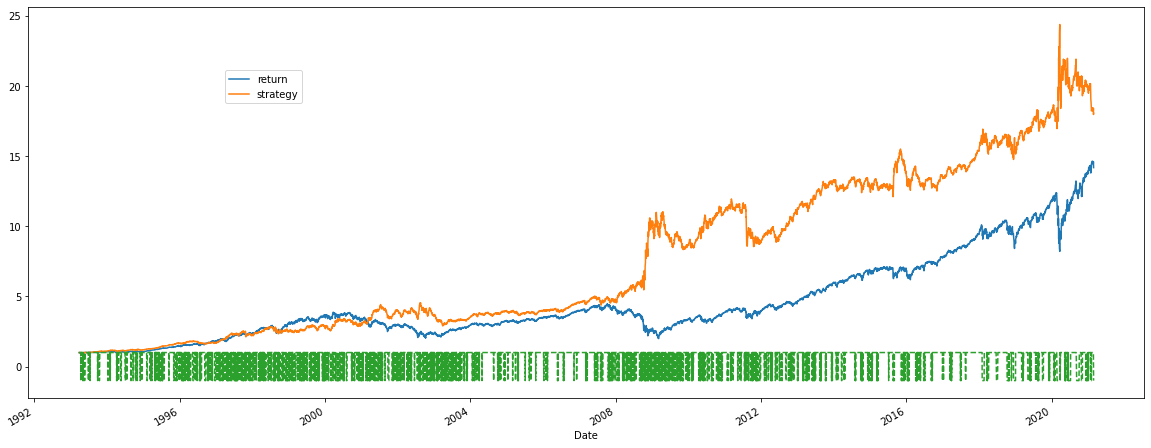

In [733]:
ax = combined_data_logistic[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(20, 8));
combined_data_logistic['prediction'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

# Lets avoid overfitting

In [734]:
from sklearn.model_selection import train_test_split

In [735]:
train, test = train_test_split(combined_data_logistic, test_size=0.5,
                               shuffle=False, random_state=100)

In [736]:
train = train.copy().sort_index()
test = test.copy().sort_index()  

In [737]:
lm.fit(train[cols], np.sign(train['return']))

LogisticRegression(C=10000000.0, max_iter=10000)

In [738]:
test['prediction'] = lm.predict(test[cols])

In [739]:
test['prediction'].value_counts()

 1.0    2135
-1.0    1381
Name: prediction, dtype: int64

In [740]:
hits = np.sign(test['return'].iloc[lags:] *
               test['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    2074
-1.0    1426
 0.0      11
dtype: int64

In [741]:
accuracy_score(test['prediction'],
               np.sign(test['return']))

0.5907281001137656

In [746]:
test['strategy'] = test['return']*test['prediction'].shift(1)

In [748]:
test[['return', 'strategy']].sum().apply(np.exp)

return      3.581814
strategy    1.400556
dtype: float64

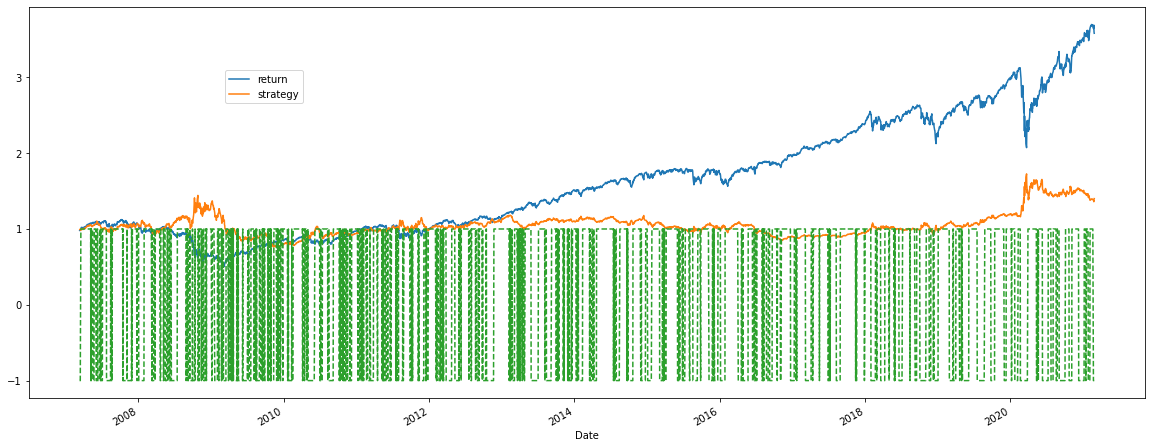

In [749]:
ax = test[['return', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(20, 8));
test['prediction'].plot(ax = ax, lw=1.5, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));

# K-Fold Cross Validation

In [526]:
k = 4
num_val_samples = len(combined_data_logistic) // k

all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = combined_data_logistic[cols][i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = np.sign(combined_data_logistic['return'])[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [combined_data_logistic[cols][:i * num_val_samples],
         combined_data_logistic[cols][(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [np.sign(combined_data_logistic['return'])[:i * num_val_samples],
         np.sign(combined_data_logistic['return'])[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    lm = linear_model.LogisticRegression(C=1e7, solver='lbfgs',
                                     multi_class='auto',
                                     max_iter=1000)
    # Train the model (in silent mode, verbose=0)
    lm.fit(partial_train_data, np.sign(partial_train_targets))
    # Evaluate the model on the validation data
    val_data['prediction'] = lm.predict(val_data)
    val_data['return'] =  combined_data_logistic['return'][i * num_val_samples: (i + 1) * num_val_samples]
    ac = accuracy_score(val_data['prediction'], np.sign(val_data['return']))
    all_scores.append(ac)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [527]:
all_scores

[0.5540386803185438,
 0.5517633674630261,
 0.5750853242320819,
 0.5915813424345847]

# Clustering

In [750]:
combined_data_logistic

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm,momentum,volatility,prediction,strategy
Date,,,,,,,,,,,,,,,,,,
1993-03-26,26.666868,-0.005552,0,0.006248,0.000000,0.002091,-0.005567,-0.001515,0.001313,0.002325,0.002606,-0.279926,-0.501370,-0.279627,0.000252,0.007443,1.0,NaN
1993-03-29,26.778231,0.004167,1,-0.005552,0.006248,0.000000,0.002091,-0.005567,0.001397,0.002184,0.002929,-0.279886,-0.500928,-0.279776,-0.000556,0.007591,1.0,0.004167
1993-03-30,26.852465,0.002768,1,0.004167,-0.005552,0.006248,0.000000,0.002091,0.001437,0.002207,0.002989,-0.279700,-0.500259,-0.279852,0.001391,0.007577,1.0,0.002768
1993-03-31,26.833904,-0.000691,0,0.002768,0.004167,-0.005552,0.006248,0.000000,0.001460,0.002230,0.003012,-0.279631,-0.499974,-0.279895,0.001526,0.006891,1.0,-0.000691
1993-04-01,26.741098,-0.003465,0,-0.000691,0.002768,0.004167,-0.005552,0.006248,0.001490,0.002209,0.003097,-0.279837,-0.500338,-0.279979,0.001388,0.006842,1.0,-0.003465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,387.029999,-0.007721,0,-0.001768,-0.004265,0.000229,-0.000866,0.004928,0.996984,0.997848,0.993797,-0.162088,-0.525438,-0.128308,-0.000348,0.009811,1.0,-0.007721
2021-02-23,387.500000,0.001214,1,-0.007721,-0.001768,-0.004265,0.000229,-0.000866,0.997415,0.998309,0.994195,-0.173743,-0.545272,-0.133390,-0.002878,0.009950,1.0,0.001214
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,0.998522,1.000000,0.994673,-0.173556,-0.535732,-0.137411,-0.002462,0.009920,1.0,0.010959


In [751]:
from sklearn.cluster import KMeans

In [788]:
k_col = cols[0:5]
k_col

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']

In [818]:
model = KMeans(algorithm = 'auto', copy_x = True, init = 'k-means++', max_iter = 300, n_clusters=3, n_init = 10, random_state=0, tol=0.0001, verbose=0)  #  <1>

In [819]:
model.fit(combined_data_logistic[k_col])

KMeans(n_clusters=3, random_state=0)

In [820]:
combined_data_logistic['pos_clus'] = model.predict(combined_data_logistic[k_col])

In [821]:
combined_data_logistic['pos_clus'] = np.where(combined_data_logistic['pos_clus'] == 2, -1, 1) 

In [822]:
combined_data_logistic['pos_clus'].values

array([ 1,  1,  1, ..., -1,  1,  1])

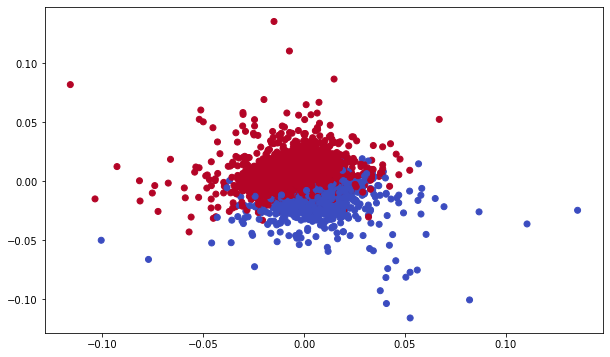

In [823]:
plt.figure(figsize=(10, 6))
plt.scatter(combined_data_logistic[cols].iloc[:, 0], combined_data_logistic[cols].iloc[:, 1],
            c=combined_data_logistic['pos_clus'], cmap='coolwarm');

In [827]:
combined_data_logistic['strat_clus'] = combined_data_logistic['return']*combined_data_logistic['pos_clus']

In [828]:
combined_data_logistic[['return', 'strat_clus']].sum().apply(np.exp)

return        14.184416
strat_clus     4.137712
dtype: float64

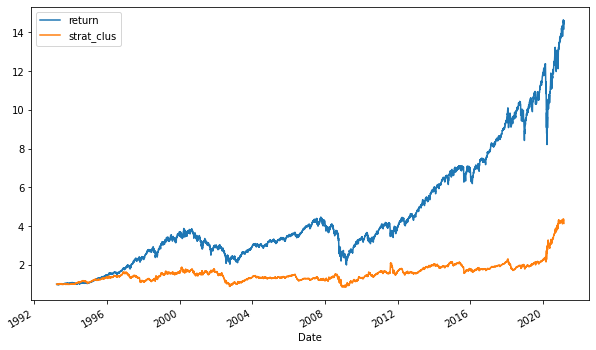

In [829]:
combined_data_logistic[['return', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# Neural Network Keras

In [830]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random

In [831]:
optimizer = Adam(learning_rate=0.0001)

In [832]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [833]:
metric = 'accuracy'

In [872]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',
        input_shape=(len(cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) # <5>
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[metric])

In [873]:
cutoff = '2012-12-31'

In [874]:
combined_data['direction'] = np.where(combined_data['return'] > 0, 1, 0)
combined_data

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm,momentum,volatility
Date,,,,,,,,,,,,,,,,
1993-03-26,26.666868,-0.005552,0,0.006248,0.000000,0.002091,-0.005567,-0.001515,0.001313,0.002325,0.002606,-0.279926,-0.501370,-0.279627,0.000252,0.007443
1993-03-29,26.778231,0.004167,1,-0.005552,0.006248,0.000000,0.002091,-0.005567,0.001397,0.002184,0.002929,-0.279886,-0.500928,-0.279776,-0.000556,0.007591
1993-03-30,26.852465,0.002768,1,0.004167,-0.005552,0.006248,0.000000,0.002091,0.001437,0.002207,0.002989,-0.279700,-0.500259,-0.279852,0.001391,0.007577
1993-03-31,26.833904,-0.000691,0,0.002768,0.004167,-0.005552,0.006248,0.000000,0.001460,0.002230,0.003012,-0.279631,-0.499974,-0.279895,0.001526,0.006891
1993-04-01,26.741098,-0.003465,0,-0.000691,0.002768,0.004167,-0.005552,0.006248,0.001490,0.002209,0.003097,-0.279837,-0.500338,-0.279979,0.001388,0.006842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,387.029999,-0.007721,0,-0.001768,-0.004265,0.000229,-0.000866,0.004928,0.996984,0.997848,0.993797,-0.162088,-0.525438,-0.128308,-0.000348,0.009811
2021-02-23,387.500000,0.001214,1,-0.007721,-0.001768,-0.004265,0.000229,-0.000866,0.997415,0.998309,0.994195,-0.173743,-0.545272,-0.133390,-0.002878,0.009950
2021-02-24,391.769989,0.010959,1,0.001214,-0.007721,-0.001768,-0.004265,0.000229,0.998522,1.000000,0.994673,-0.173556,-0.535732,-0.137411,-0.002462,0.009920


In [875]:
training_data = combined_data[combined_data.index < cutoff].copy()

In [876]:
mu, std = training_data.mean(), training_data.std()

In [877]:
training_data_ = (training_data - mu) / std
training_data_

,SPY,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,bb_bbm_norm,bb_bbh_norm,bb_bbl_norm,macd_norm,macd_diff_norm,macd_signal_norm,momentum,volatility
Date,,,,,,,,,,,,,,,,
1993-03-26,-1.913356,-0.471651,-1.067673,0.479016,-0.024526,0.143885,-0.473180,-0.146812,-1.907237,-1.929455,-1.876323,-0.057382,-0.077121,-0.036202,-0.010639,-0.496117
1993-03-29,-1.909128,0.311593,0.936428,-0.471955,0.478995,-0.024628,0.143923,-0.473329,-1.906085,-1.931387,-1.871899,-0.056028,-0.058367,-0.040788,-0.170808,-0.473347
1993-03-30,-1.906310,0.198856,0.936428,0.311334,-0.471978,0.478898,-0.024588,0.143808,-1.905529,-1.931076,-1.871086,-0.049624,-0.029998,-0.043095,0.215355,-0.475552
1993-03-31,-1.907014,-0.079944,-1.067673,0.198590,0.311313,-0.472085,0.478931,-0.024712,-1.905219,-1.930766,-1.870777,-0.047229,-0.017913,-0.044432,0.242226,-0.580919
1993-04-01,-1.910538,-0.303407,-1.067673,-0.080226,0.198569,0.311214,-0.472038,0.478835,-1.904805,-1.931056,-1.869616,-0.054317,-0.033342,-0.047008,0.214795,-0.588410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-21,1.710650,-0.759031,-1.067673,0.437751,-0.625503,0.867270,0.916973,-0.324712,1.680876,1.615614,1.743773,0.710104,0.741769,0.516292,0.626081,-0.696359
2012-12-24,1.696365,-0.272894,-1.067673,-0.759353,0.437730,-0.625612,0.867297,0.916902,1.684603,1.616678,1.750316,0.641375,0.411282,0.549423,0.412004,-0.719944
2012-12-26,1.676883,-0.364580,-1.067673,-0.273187,-0.759376,0.437633,-0.625562,0.867223,1.688517,1.612811,1.762482,0.534963,0.047168,0.553313,-0.173935,-0.715487


In [878]:
test_data = combined_data[combined_data.index >= cutoff].copy()

In [879]:
#test_data_ = (test_data - mu) / std

In [880]:
%%time
model.fit(training_data[cols],
          training_data['direction'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False)

Wall time: 6.43 s


In [881]:
res = pd.DataFrame(model.history.history)

In [882]:
res.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693159,0.51783,0.687953,0.557229
1,0.692086,0.52662,0.688133,0.557229
2,0.691972,0.52662,0.688196,0.557229
3,0.691906,0.52662,0.688216,0.557229
4,0.691865,0.52662,0.688214,0.557229


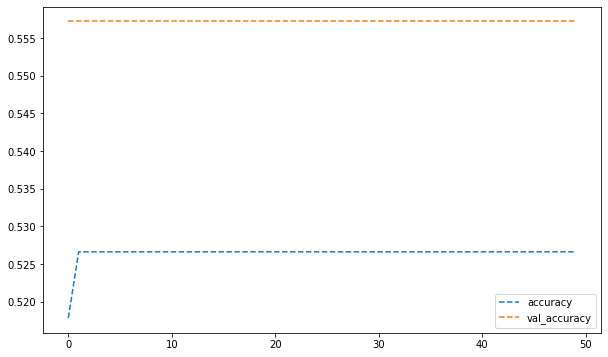

In [883]:
res[[metric, 'val_' + metric]].plot(figsize=(10, 6), style='--');

In [884]:
model.evaluate(training_data_[cols], training_data['direction'])

156/156 [==============================] - 0s 463us/step - loss: 0.8152 - accuracy: 0.5070


[0.8151758313179016, 0.5070309638977051]

In [885]:
pred = model.predict_classes(training_data_[cols])

C:\Users\Ferhat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [886]:
pred[:30].flatten()

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0])

In [887]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [888]:
training_data['strategy'] = (training_data['prediction'] *
                            training_data['return'])

In [889]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      4.466181
strategy    3.207154
dtype: float64

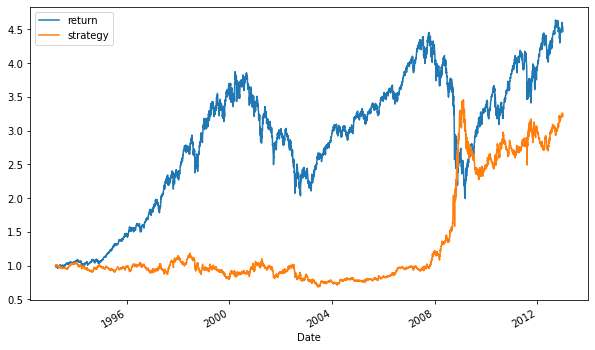

In [890]:
training_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));

In [891]:
model.evaluate(test_data_[cols], test_data['direction'])

65/65 [==============================] - 0s 483us/step - loss: 1.0887 - accuracy: 0.4805


[1.0886510610580444, 0.48052579164505005]

In [892]:
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'bb_bbm_norm',
 'bb_bbh_norm',
 'bb_bbl_norm',
 'macd_norm',
 'macd_diff_norm',
 'macd_signal_norm',
 'momentum',
 'volatility']

In [893]:
pred = model.predict_classes(test_data_[cols])

C:\Users\Ferhat\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [894]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [895]:
test_data['prediction'].value_counts()

-1    1669
 1     385
Name: prediction, dtype: int64

In [896]:
test_data['strategy'] = (test_data['prediction'] *
                        test_data['return'])

In [897]:
test_data[['return', 'strategy']].sum().apply(np.exp)

return      3.175961
strategy    2.087814
dtype: float64

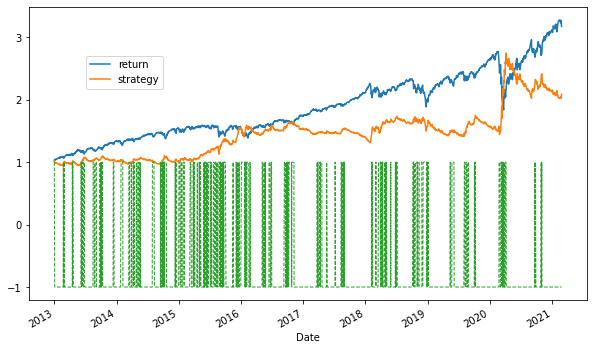

In [898]:
ax = test_data[['return', 'strategy']].cumsum(
                ).apply(np.exp).plot(figsize=(10, 6));
test_data['prediction'].plot(ax = ax, lw=1, secondary_y = 'Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85));